# Let! Him! Cook!

**Name**: Eugene Myong

**Website Link**: https://eugene-myong.github.io/Let-Him-Cook/

In [117]:
import pandas as pd
import numpy as np
from pathlib import Path

import plotly.express as px
pd.options.plotting.backend = 'plotly'

from dsc80_utils import * # Feel free to uncomment and use this.

In [118]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [119]:
import matplotlib.pyplot as plt

## Step 1: Introduction

In [120]:
# Loading the data
recipes_fp = Path('data') / 'RAW_recipes.csv'
recipes = pd.read_csv(recipes_fp)
recipes.head()

name      id  minutes  contributor_id  ...  \
0  1 brownies in the world    best ever  333281       40          985201  ...   
1    1 in canada chocolate chip cookies  453467       45         1848091  ...   
2                412 broccoli casserole  306168       40           50969  ...   
3                millionaire pound cake  286009      120          461724  ...   
4                         2000 meatloaf  475785       90         2202916  ...   

                                               steps  \
0  ['heat the oven to 350f and arrange the rack i...   
1  ['pre-heat oven the 350 degrees f', 'in a mixi...   
2  ['preheat oven to 350 degrees', 'spray a 2 qua...   
3  ['freheat the oven to 300 degrees', 'grease a ...   
4  ['pan fry bacon , and set aside on a paper tow...   

                                         description  \
0  these are the most; chocolatey, moist, rich, d...   
1  this is the recipe that we use at my school ca...   
2  since there are already 411 recipes for brocco...   
3  why a millionaire pound cake?  because it's su...   
4  ready, set, cook! special edition contest entr...   

                                         ingredients  n_ingredients  
0  ['bittersweet chocolate', 'unsalted butter', '...              9  
1  ['white sugar', 'brown sugar', 'salt', 'margar...             11  
2  ['frozen broccoli cuts', 'cream of chicken sou...              9  
3  ['butter', 'sugar', 'eggs', 'all-purpose flour...              7  
4  ['meatloaf mixture', 'unsmoked bacon', 'goat c...             13  

[5 rows x 12 columns]

In [121]:
reviews_fp = Path('data') / 'RAW_interactions.csv'
reviews = pd.read_csv(reviews_fp)
reviews.head()

user_id  recipe_id        date  rating  \
0     1293707      40893  2011-12-21       5   
1      126440      85009  2010-02-27       5   
2       57222      85009  2011-10-01       5   
3      124416     120345  2011-08-06       0   
4  2000192946     120345  2015-05-10       2   

                                              review  
0  So simple, so delicious! Great for chilly fall...  
1  I made the Mexican topping and took it to bunk...  
2  Made the cheddar bacon topping, adding a sprin...  
3  Just an observation, so I will not rate.  I fo...  
4  This recipe was OVERLY too sweet.  I would sta...

In [122]:
# Combining the two dataframes
merged = recipes.merge(
    reviews,
    how='left',
    left_on='id',
    right_on='recipe_id'
)

In [123]:
# Replacing all 0 ratings with nan
merged['rating'] = merged['rating'].replace(0, np.nan)

In [124]:
# Finding the average rating of all recipes
avg_rating = merged.groupby('id')['rating'].mean()

In [125]:
# Adding the avg_rating column back to recipes, we will use this for the project!
recipes = recipes.merge(
    avg_rating.rename("avg_rating"),
    how='left',
    left_on='id',
    right_index=True
)
recipes.head()

name      id  minutes  contributor_id  ...  \
0  1 brownies in the world    best ever  333281       40          985201  ...   
1    1 in canada chocolate chip cookies  453467       45         1848091  ...   
2                412 broccoli casserole  306168       40           50969  ...   
3                millionaire pound cake  286009      120          461724  ...   
4                         2000 meatloaf  475785       90         2202916  ...   

                                         description  \
0  these are the most; chocolatey, moist, rich, d...   
1  this is the recipe that we use at my school ca...   
2  since there are already 411 recipes for brocco...   
3  why a millionaire pound cake?  because it's su...   
4  ready, set, cook! special edition contest entr...   

                                         ingredients n_ingredients  avg_rating  
0  ['bittersweet chocolate', 'unsalted butter', '...             9         4.0  
1  ['white sugar', 'brown sugar', 'salt', 'margar...            11         5.0  
2  ['frozen broccoli cuts', 'cream of chicken sou...             9         5.0  
3  ['butter', 'sugar', 'eggs', 'all-purpose flour...             7         5.0  
4  ['meatloaf mixture', 'unsmoked bacon', 'goat c...            13         5.0  

[5 rows x 13 columns]

The big question: What types of recipes tend to have different numbers of steps?

In [126]:
recipes.shape

(83782, 13)

## Step 2: Data Cleaning and Exploratory Data Analysis

### Data Cleaning

In [127]:
# Normalize name and remove repeating whitespaces
recipes['name'] = recipes['name'].str.lower().str.strip()
recipes['name'] = recipes['name'].str.replace(r"\s+", " ", regex=True)

In [128]:
# Normalize description
recipes['description'] = recipes['description'].str.lower().str.strip()

In [129]:
# Changing the submitted column to timestamp objects
recipes['submitted'] = pd.to_datetime(recipes['submitted'], errors='coerce')

In [130]:
# Function that parses strings (for the stringified lists)
def parse_string_list(s):
    s = s.strip()
    if s.startswith("[") and s.endswith("]"):
        s = s[1:-1]
    items = []
    current = ""
    inside_quotes = False
    i = 0
    while i < len(s):
        ch = s[i]
        if ch == "'" and (i == 0 or s[i-1] != "\\"):
            inside_quotes = not inside_quotes
            i += 1
            continue

        if ch == "," and not inside_quotes:
            items.append(current.strip().strip("'").strip())
            current = ""
            i += 1
            continue
        
        current += ch
        i += 1

    if current.strip():
        items.append(current.strip().strip("'").strip())

    return items

In [131]:
# Apply to columns with the stringified list format
recipes['tags'] = recipes['tags'].apply(parse_string_list)
recipes['steps'] = recipes['steps'].apply(parse_string_list)
recipes['ingredients'] = recipes['ingredients'].apply(parse_string_list)

In [132]:
# Ensure that the number of steps and ingredients is correct
recipes['n_steps'] = recipes['steps'].str.len()
recipes['n_ingredients'] = recipes['ingredients'].str.len()

In [133]:
# Normalize ingredients
recipes['ingredients'] = recipes['ingredients'].apply(
    lambda lst: [ing.lower().strip() for ing in lst])

In [134]:
# Function that splits the nutrition column into seven different columns, one for each nutrition fact
def split_nutrition_columns(df):
    # Parse numeric list 
    def parse_numeric_list(s):
        s = s.strip()[1:-1].strip()
        if len(s) == 0:
            return []
        return [float(x.strip()) for x in s.split(",")]

    nutrition_lists = df['nutrition'].apply(parse_numeric_list)
    nutrition_cols = ['calories', 'total_fat_pct', 'sugar', 'sodium', 'protein', 'saturated_fat', 'carbs']
    df[nutrition_cols] = pd.DataFrame(nutrition_lists.tolist(), index=df.index)
    return df

In [135]:
# Apply splitting function to the recipes dataframe
recipes = split_nutrition_columns(recipes)
# Drop old nutrition column
recipes = recipes.drop(columns=['nutrition'])

In [136]:
# Clean the tags column
recipes['tags'] = recipes['tags'].apply(
    lambda lst: [tag.lower().strip() for tag in lst]
)
# Remove duplicates in tags
recipes['tags'] = recipes['tags'].apply(lambda lst: list(dict.fromkeys(lst)))

In [137]:
# Create columns for the year, month, and weekday submitted
recipes['year'] = recipes['submitted'].dt.year
recipes['month'] = recipes['submitted'].dt.month
recipes['weekday'] = recipes['submitted'].dt.day_name()

In [138]:
# Example: First observation in dataframe
recipes.iloc[0].to_dict()

{'name': '1 brownies in the world best ever',
 'id': 333281,
 'minutes': 40,
 'contributor_id': 985201,
 'submitted': Timestamp('2008-10-27 00:00:00'),
 'tags': ['60-minutes-or-less',
  'time-to-make',
  'course',
  'main-ingredient',
  'preparation',
  'for-large-groups',
  'desserts',
  'lunch',
  'snacks',
  'cookies-and-brownies',
  'chocolate',
  'bar-cookies',
  'brownies',
  'number-of-servings'],
 'n_steps': 10,
 'steps': ['heat the oven to 350f and arrange the rack in the middle',
  'line an 8-by-8-inch glass baking dish with aluminum foil',
  'combine chocolate and butter in a medium saucepan and cook over medium-low heat , stirring frequently , until evenly melted',
  'remove from heat and let cool to room temperature',
  'combine eggs , sugar , cocoa powder , vanilla extract , espresso , and salt in a large bowl and briefly stir until just evenly incorporated',
  'add cooled chocolate and mix until uniform in color',
  'add flour and stir until just incorporated',
  'transf

In [139]:
# Information on columns of dataframe
recipes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83782 entries, 0 to 83781
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   name            83781 non-null  object        
 1   id              83782 non-null  int64         
 2   minutes         83782 non-null  int64         
 3   contributor_id  83782 non-null  int64         
 4   submitted       83782 non-null  datetime64[ns]
 5   tags            83782 non-null  object        
 6   n_steps         83782 non-null  int64         
 7   steps           83782 non-null  object        
 8   description     83712 non-null  object        
 9   ingredients     83782 non-null  object        
 10  n_ingredients   83782 non-null  int64         
 11  avg_rating      81173 non-null  float64       
 12  calories        83782 non-null  float64       
 13  total_fat_pct   83782 non-null  float64       
 14  sugar           83782 non-null  float64       
 15  so

In [140]:
recipes.head()

name      id  minutes  contributor_id  ...  \
0   1 brownies in the world best ever  333281       40          985201  ...   
1  1 in canada chocolate chip cookies  453467       45         1848091  ...   
2              412 broccoli casserole  306168       40           50969  ...   
3              millionaire pound cake  286009      120          461724  ...   
4                       2000 meatloaf  475785       90         2202916  ...   

  carbs  year  month  weekday  
0   6.0  2008     10   Monday  
1  26.0  2011      4   Monday  
2   3.0  2008      5   Friday  
3  39.0  2008      2  Tuesday  
4   2.0  2012      3  Tuesday  

[5 rows x 22 columns]

In [141]:
def clean_and_truncate(x, max_len=40):
    x = str(x)

    # Escape brackets for Markdown
    x = x.replace("[", r"\[").replace("]", r"\]")

    # Truncate if too long
    return x if len(x) <= max_len else x[:max_len] + "..."

preview = recipes.head().applymap(clean_and_truncate)
print(preview.to_markdown(index=False))


| name                               |     id |   minutes |   contributor_id | submitted           | tags                                        |   n_steps | steps                                       | description                                 | ingredients                                 |   n_ingredients |   avg_rating |   calories |   total_fat_pct |   sugar |   sodium |   protein |   saturated_fat |   carbs |   year |   month | weekday   |
|:-----------------------------------|-------:|----------:|-----------------:|:--------------------|:--------------------------------------------|----------:|:--------------------------------------------|:--------------------------------------------|:--------------------------------------------|----------------:|-------------:|-----------:|----------------:|--------:|---------:|----------:|----------------:|--------:|-------:|--------:|:----------|
| 1 brownies in the world best ever  | 333281 |        40 |           985201 | 2008-10-27 00:0

C:\Users\eugen\AppData\Local\Temp\ipykernel_23088\4141882441.py:10: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



### Univariate Analysis

In [142]:
# Figure that shows distribution of number of steps
fig = px.histogram(
    recipes,
    x="n_steps",
    nbins=30,
    title="Distribution of Number of Steps",
)
fig.update_xaxes(range=[0, 60])
fig.update_layout(
    xaxis_title="Steps",
    yaxis_title="Count"
)
fig.show()

In [143]:
fig.write_html("assets/num-steps-hist.html", include_plotlyjs="cdn")

In [144]:
recipes["n_steps"].max()

np.int64(87)

In [145]:
# Figure that shows distribution of number of ingredients
fig = px.histogram(
    recipes,
    x="n_ingredients",
    nbins=25,
    title="Distribution of Number of Ingredients",
)
fig.update_layout(
    xaxis_title="Number of Ingredients",
    yaxis_title="Count"
)
fig.show()

In [146]:
# Figure that shows the distribution of average ratings
fig = px.histogram(
    recipes,
    x="avg_rating",
    nbins=20,
    title="Distribution of Average Recipe Ratings",
)
fig.update_layout(
    xaxis_title="Average Rating",
    yaxis_title="Count"
)
fig.show()

In [147]:
# Figure that shows distribution of calories
fig = px.histogram(
    recipes,
    x="calories",
    nbins=40,
    title="Distribution of Calories"
)

fig.update_layout(
    xaxis_title="Calories",
    yaxis_title="Count"
)

fig.show()

In [148]:
# Figure that shows distribution of minutes needed (binned)
recipes["minutes_bin"] = pd.cut(
    recipes["minutes"],
    bins=[0, 15, 30, 60, 120, 1e6],
    labels=["<15", "15–30", "30–60", "60–120", ">120"]
)
fig = px.histogram(
    recipes,
    x="minutes_bin",
    title="Distribution of Recipe Counts by Minutes Bin",
)

fig.update_layout(
    xaxis_title="Minutes Category",
    yaxis_title="Number of Recipes"
)

fig.show()

### Bivariate Analysis

In [149]:
# Figure that shows number of steps vs average rating
fig = px.scatter(
    recipes,
    x="n_steps",
    y="avg_rating",
    opacity=0.4,
    title="Number of Steps vs Average Rating"
)

fig.update_layout(
    xaxis_title="Number of Steps",
    yaxis_title="Average Rating"
)

fig.show()

In [150]:
fig.write_html("assets/num-steps-avg-rating-scatter.html", include_plotlyjs="cdn")

In [ ]:
# Figure that shows number of ingredients by average rating
fig = px.box(
    recipes,
    x="avg_rating",
    y="n_ingredients",
    category_orders={"avg_rating": [1, 2, 3, 4, 5]},
    title="Number of Ingredients by Rating (1–5)",
)

fig.update_layout(
    xaxis_title="Average Rating",
    yaxis_title="Number of Ingredients"
)

fig.show()

In [33]:
# Figure that shows the minutes vs average rating
fig = px.scatter(
    recipes,
    x="minutes",
    y="avg_rating",
    opacity=0.4,
    title="Minutes vs Average Rating (Log Scale)"
)
fig.update_xaxes(type="log", title="Minutes (log scale)")
fig.update_yaxes(title="Average Rating")
fig.show()

In [34]:
# Figure that shows calories vs average rating
fig = px.scatter(
    recipes,
    x="calories",
    y="avg_rating",
    opacity=0.4,
    title="Calories vs Average Rating"
)

fig.update_layout(
    xaxis_title="Calories",
    yaxis_title="Average Rating"
)

fig.show()

In [35]:
# Figure that shows minutes (binned) vs average rating
minutes_rating = (
    recipes.groupby("minutes_bin")["avg_rating"]
           .mean()
           .reset_index()
)


fig = px.bar(
    minutes_rating,
    x="minutes_bin",
    y="avg_rating",
    title="Average Rating by Minutes Bin",
)

fig.update_layout(
    xaxis_title="Minutes Category",
    yaxis_title="Average Rating",
)

fig.show()

C:\Users\eugen\AppData\Local\Temp\ipykernel_23088\1385040772.py:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



### Interesting Aggregates

In [39]:
# Do recipes with different numbers of steps have different average ratings?
recipes.groupby("n_steps")["avg_rating"].mean()

n_steps
1     4.65
2     4.67
3     4.65
      ... 
81    4.00
83    5.00
87    5.00
Name: avg_rating, Length: 77, dtype: float64

In [40]:
# Do recipes with different numbers of ingredients have different average ratings?
recipes.groupby("n_ingredients")["avg_rating"].mean()

n_ingredients
1     4.64
2     4.67
3     4.67
      ... 
32    5.00
33    5.00
37    5.00
Name: avg_rating, Length: 34, dtype: float64

In [36]:
# Do different years have different average ratings?
recipes.groupby("year")["avg_rating"].mean()

year
2008    4.60
2009    4.62
2010    4.64
        ... 
2016    4.53
2017    4.47
2018    4.61
Name: avg_rating, Length: 11, dtype: float64

In [41]:
# Do different amounts of calories have different average ratings?
recipes["calories_bin"] = pd.cut(
    recipes["calories"],
    bins=[0, 100, 200, 300, 400, 500, 1000, recipes["calories"].max()],
    labels=["<100", "100–200", "200–300", "300–400", "400–500", "500–1000", ">1000"]
)
recipes.groupby("calories_bin")["avg_rating"].mean()

C:\Users\eugen\AppData\Local\Temp\ipykernel_23088\2489168801.py:7: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



calories_bin
<100        4.65
100–200     4.63
200–300     4.62
300–400     4.62
400–500     4.62
500–1000    4.62
>1000       4.62
Name: avg_rating, dtype: float64

In [42]:
# Do different amounts of required time (minutes) have different average ratings?
recipes.groupby("minutes_bin")["avg_rating"].mean()

C:\Users\eugen\AppData\Local\Temp\ipykernel_23088\3966422819.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



minutes_bin
<15       4.67
15–30     4.62
30–60     4.61
60–120    4.63
>120      4.59
Name: avg_rating, dtype: float64

In [43]:
# Do recipes with varying amounts of ingredients change in popularity over time?
pd.pivot_table(
    recipes,
    values="avg_rating",
    index="year",
    columns="n_ingredients",
    aggfunc="mean"
)

n_ingredients    1     2     3     4   ...   31   32   33  37
year                                   ...                   
2008           4.70  4.67  4.65  4.62  ...  5.0  NaN  NaN NaN
2009           4.54  4.70  4.72  4.68  ...  NaN  5.0  5.0 NaN
2010           4.85  4.65  4.61  4.60  ...  5.0  NaN  NaN NaN
...             ...   ...   ...   ...  ...  ...  ...  ...  ..
2016            NaN  5.00  4.00  4.61  ...  NaN  NaN  NaN NaN
2017           4.00  5.00  4.46  5.00  ...  5.0  NaN  NaN NaN
2018            NaN  5.00  4.44  4.67  ...  NaN  NaN  NaN NaN

[11 rows x 34 columns]

In [44]:
# Do recipes with varying amounts of steps change in popularity over time?
pd.pivot_table(
    recipes,
    values="avg_rating",
    index="year",
    columns="n_steps",
    aggfunc="mean"
)

n_steps    1     2     3     4   ...   80  81  83   87
year                             ...                  
2008     4.60  4.66  4.62  4.61  ...  NaN NaN NaN  5.0
2009     4.71  4.66  4.66  4.63  ...  NaN NaN NaN  NaN
2010     4.68  4.70  4.66  4.64  ...  NaN NaN NaN  NaN
...       ...   ...   ...   ...  ...  ...  ..  ..  ...
2016      NaN  4.86  4.60  5.00  ...  NaN NaN NaN  NaN
2017      NaN  4.11  4.79  4.43  ...  NaN NaN NaN  NaN
2018      NaN  4.75  4.88  4.44  ...  5.0 NaN NaN  NaN

[11 rows x 77 columns]

In [45]:
# Do seasonal recipes require more time and/or are rated differently?
pd.pivot_table(
    recipes,
    values="avg_rating",
    index="month",
    columns="minutes_bin",
    aggfunc="mean"
)

C:\Users\eugen\AppData\Local\Temp\ipykernel_23088\1453901271.py:2: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior



minutes_bin   <15  15–30  30–60  60–120  >120
month                                        
1            4.65   4.59   4.57    4.61  4.55
2            4.66   4.58   4.59    4.61  4.58
3            4.68   4.63   4.63    4.61  4.59
...           ...    ...    ...     ...   ...
10           4.64   4.62   4.60    4.62  4.55
11           4.64   4.58   4.60    4.65  4.56
12           4.68   4.61   4.60    4.64  4.63

[12 rows x 5 columns]

In [151]:
# Are the number of steps and number of ingredients related in how the affect the average rating?
si = pd.pivot_table(
    recipes,
    values="avg_rating",
    index="n_steps",
    columns="n_ingredients",
    aggfunc="mean"
)

In [152]:
print(si.head().to_markdown(index=False))

|       1 |       2 |       3 |       4 |       5 |       6 |       7 |       8 |       9 |      10 |      11 |      12 |      13 |      14 |        15 |      16 |      17 |        18 |        19 |        20 |        21 |      22 |   23 |    24 |   25 |   26 |   27 |   28 |   29 |   30 |   31 |   32 |   33 |   37 |
|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|----------:|--------:|--------:|----------:|----------:|----------:|----------:|--------:|-----:|------:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|
| 4.66667 | 4.66299 | 4.7662  | 4.69459 | 4.66742 | 4.64639 | 4.55043 | 4.55658 | 4.56284 | 4.59369 | 4.58182 | 4.59259 | 4.5     | 4.68333 | nan       | 4.6     | 4.88889 | nan       | nan       | nan       | nan       | nan     |  nan | nan   |  nan |  nan |  nan |  nan |  nan |  nan |  nan |  nan |  nan |  nan |
| 4.80769 | 4.70988 | 4.67926 | 4.68089 | 4.65886

In [47]:
# Does the time required or calories affect the number of steps required?
pd.pivot_table(
    recipes,
    values="n_steps",
    index="calories_bin",
    columns="minutes_bin",
    aggfunc="mean"
)

C:\Users\eugen\AppData\Local\Temp\ipykernel_23088\1954068098.py:2: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior



minutes_bin    <15  15–30  30–60  60–120   >120
calories_bin                                   
<100          4.75   8.19  10.17   10.72   9.52
100–200       5.17   8.68  10.33   11.42  10.78
200–300       5.64   8.98  10.94   12.14  10.86
300–400       5.82   9.39  11.16   12.65  11.01
400–500       6.09   9.50  11.63   12.96  11.94
500–1000      6.35  10.12  12.26   14.14  13.72
>1000         6.25  10.18  12.79   14.17  14.63

## Step 3: Assessment of Missingness

The column we will analyze for missingness if avg_rating.

In [48]:
recipes['avg_rating_missing'] = recipes['avg_rating'].isna()

In [49]:
def permutation_test_diff_in_means(df, missing_col, value_col, n_reps=1000, random_state=0):
    """
    Tests whether the distribution of `value_col` differs between rows where
    `missing_col` is True (missing) vs False (observed), using a permutation
    test with difference in means as the test statistic.
    """
    rng = np.random.default_rng(random_state)
    
    # Boolean array: True = missing, False = observed
    miss = df[missing_col].values
    vals = df[value_col].values

    # Observed statistic: absolute difference in means
    obs = np.abs(vals[miss].mean() - vals[~miss].mean())

    stats = np.zeros(n_reps)
    for i in range(n_reps):
        shuffled = rng.permutation(miss)
        stats[i] = np.abs(vals[shuffled].mean() - vals[~shuffled].mean())

    # Two-sided p-value
    p_val = np.mean(stats >= obs)
    return obs, stats, p_val

In [50]:
obs_steps, stats_steps, p_steps = permutation_test_diff_in_means(
    recipes,
    missing_col='avg_rating_missing',
    value_col='n_steps',
    n_reps=1000,
    random_state=0
)

print("Missingness vs n_steps")
print("Observed avg_steps_difference:", obs_steps)
print("Permutation p-value:", p_steps)

Missingness vs n_steps
Observed avg_steps_difference: 1.3683089078936614
Permutation p-value: 0.0


In [51]:
stats_steps_df = pd.DataFrame({'stat': stats_steps})
fig = px.histogram(
    stats_steps_df,
    x='stat',
    nbins=30,
    title='Null Distribution of |Δ mean n_steps| under MCAR'
)
fig.add_vline(x=obs_steps, line_color='red', line_width=3)
fig.update_layout(
    xaxis_title='|Δ mean n_steps|',
    yaxis_title='Count'
)
fig.show()

With a small p-value of 0 (which is < 0.05), we reject the null hypothesis and say that avg rating is dependent on the number of steps, with missingness mechanism MAR.



In [52]:
print(recipes.loc[recipes["avg_rating_missing"], "n_steps"].mean())
print(recipes.loc[~recipes["avg_rating_missing"], "n_steps"].mean())

11.233806055960137
9.865497148066476


More complex recipes (more steps) are more likely to be missing ratings.

In [53]:
recipes["weekday_code"] = recipes["weekday"].astype("category").cat.codes

In [54]:
obs_weekday, stats_weekday, p_weekday = permutation_test_diff_in_means(
    recipes,
    missing_col="avg_rating_missing",
    value_col="weekday_code",
    n_reps=1000,
    random_state=0
)

print("Missingness vs weekday")
print("Observed difference in average weekday code:", obs_weekday)
print("Permutation p-value:", p_weekday)



Missingness vs weekday
Observed difference in average weekday code: 0.06896464434612337
Permutation p-value: 0.099


In [55]:
stats_weekday_df = pd.DataFrame({"stat": stats_weekday})

fig = px.histogram(
    stats_weekday_df,
    x="stat",
    nbins=30,
    title="Null Distribution of Difference in Average Weekday"
)

# Observed statistic line
fig.add_vline(
    x=obs_weekday,
    line_color="red",
    line_width=3,
    name="Observed statistic"
)

fig.update_layout(
    xaxis_title="Difference in Average Weekday Code",
    yaxis_title="Count"
)

fig.show()

With a large p value (> 0.05) we say that we fail to reject the null hypothesis, or that avg_rating is not dependent on weekday.

## Step 4: Hypothesis Testing

We aim to find an answer to the question: What types of recipes tend to have more steps?

To do so, we will analyze the number of ingredients of a recipe.

Null Hypothesis: Recipes with more ingredients have the same mean number of steps as recipes with fewer ingredients.

Alternative Hypothesis: Recipes with more ingredients have a different mean number of steps than recipes with fewer ingredients.

In [56]:
# Drop missing step or ingredient values if any
clean = recipes.dropna(subset=["n_steps", "n_ingredients"]).copy()

# Create high/low ingredient groups based on median
median_ing = clean["n_ingredients"].median()
clean["high_ing"] = (clean["n_ingredients"] > median_ing).astype(int)

# Compute observed difference in mean number of steps
obs_diff = abs(
    clean.loc[clean["high_ing"] == 1, "n_steps"].mean()
    - clean.loc[clean["high_ing"] == 0, "n_steps"].mean()
)

obs_diff

np.float64(4.357054139807378)

In [57]:
# Permutation test
N = 1000
rng = np.random.default_rng(0)
perm_diffs = []

labels = clean["high_ing"].to_numpy()
steps = clean["n_steps"].to_numpy()

for _ in range(N):
    shuffled = rng.permutation(labels)

    mean_high = steps[shuffled == 1].mean()
    mean_low = steps[shuffled == 0].mean()

    perm_diffs.append(abs(mean_high - mean_low))

perm_diffs = np.array(perm_diffs)


In [58]:
stats_steps = []
N = 1000
rng = np.random.default_rng(0)

# Drop rows with missing n_steps or avg_rating (to avoid NaNs)
clean = recipes.dropna(subset=["avg_rating", "n_steps"]).copy()

median_rating = clean["avg_rating"].median()
clean["rating_group"] = clean["avg_rating"] > median_rating

for _ in range(N):
    shuffled = rng.permutation(clean["rating_group"].values)

    stat = (
        clean["n_steps"]
        .groupby(shuffled)       # now safe because we passed .values
        .mean()
        .diff()
        .abs()
        .iloc[-1]
    )

    stats_steps.append(stat)

stats_steps = np.array(stats_steps)

# Remove any NaN values just in case
stats_steps = stats_steps[~np.isnan(stats_steps)]


In [59]:
p_val = (perm_diffs >= obs_diff).mean()
p_val

np.float64(0.0)

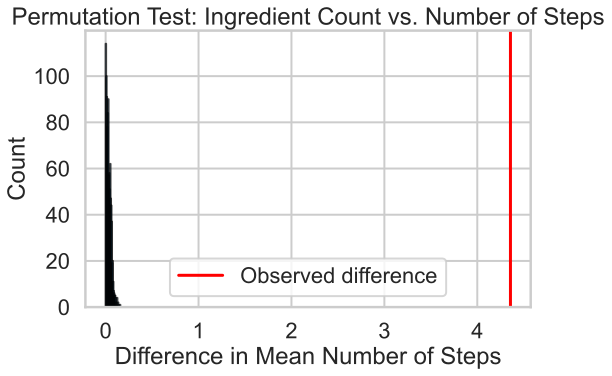

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(perm_diffs, bins=30, edgecolor="black", alpha=0.7)
plt.axvline(obs_diff, color="red", linewidth=3, label="Observed difference")
plt.xlabel("Difference in Mean Number of Steps")
plt.ylabel("Count")
plt.title("Permutation Test: Ingredient Count vs. Number of Steps")
plt.legend()
plt.show()


With a test statistic of difference in means, a significance level of α = 0.05, and a p-value of 0.0, we conclude that we reject the null hypothesis, leading to the conclusion that the number of ingredients of a recipe does impact the number of steps of a recipe.

## Step 5: Framing a Prediction Problem

Prediction Problem: Predict the number of steps of a recipe. This is a regression problem with response variable n_steps, with metric RMSE.

The info we know at the time of prediction is everything in the recipes dataframe. We will not have

In [61]:
recipes.columns

Index(['name', 'id', 'minutes', 'contributor_id', 'submitted', 'tags',
       'n_steps', 'steps', 'description', 'ingredients', 'n_ingredients',
       'avg_rating', 'calories', 'total_fat_pct', 'sugar', 'sodium', 'protein',
       'saturated_fat', 'carbs', 'year', 'month', 'weekday', 'minutes_bin',
       'calories_bin', 'avg_rating_missing', 'weekday_code'],
      dtype='object')

## Step 6: Baseline Model

In [62]:
recipes.columns

Index(['name', 'id', 'minutes', 'contributor_id', 'submitted', 'tags',
       'n_steps', 'steps', 'description', 'ingredients', 'n_ingredients',
       'avg_rating', 'calories', 'total_fat_pct', 'sugar', 'sodium', 'protein',
       'saturated_fat', 'carbs', 'year', 'month', 'weekday', 'minutes_bin',
       'calories_bin', 'avg_rating_missing', 'weekday_code'],
      dtype='object')

In [63]:
# Feature columns and target column
feature_cols = ["n_ingredients", "minutes"]
target_col = "n_steps"

# Drop observations without an average rating, and also drop the avg_rating_missing column.
df = (
    recipes
    .dropna(subset=[target_col])      # need rating as input feature
    .drop(columns=["avg_rating_missing"])
)

X = df[feature_cols]
y = df[target_col]

In [64]:
# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=3
)

In [65]:
# Preprocessing the data
preproc = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), feature_cols)
    ],
    remainder="drop"
)

In [66]:
# Pipeline
baseline_model = Pipeline(
    steps=[
        ("preprocess", preproc),
        ("lin_reg", LinearRegression())
    ]
)

In [67]:
# Fitting the model
baseline_model.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['n_ingredients',
                                                   'minutes'])])),
                ('lin_reg', LinearRegression())])

In [68]:
y_pred = baseline_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse


np.float64(5.580053906345429)

## Step 7: Final Model

For my final model, I am using a RandomForestRegressor, which has several important hyperparameters that control the complexity and generalization ability of the model. I will tune the following:

🔧 1. n_estimators (number of trees in the forest)

What it controls:
How many decision trees the random forest contains.

Why tune it:

More trees generally reduce variance (better generalization).

Too many trees increase training time without much benefit.

I want to find the point where performance stops improving.

Values I will test:
[100, 200, 400]

🔧 2. max_depth (maximum depth of each tree)

What it controls:
How many splits each tree is allowed to make.

Why tune it:

Shallow trees → underfitting

Deep trees → overfitting

The ideal depth balances these and gives the best RMSE.

Values I will test:
[None, 10, 20]
(None lets trees grow fully)

🔧 3. min_samples_leaf (minimum number of samples per leaf)

What it controls:
How "smooth" or "noisy" each tree's predictions are.

Why tune it:

Very small leaves → trees memorize the training data (overfitting)

Larger leaves → smoother, more stable predictions

Helps avoid overfitting when many engineered features are present

Values I will test:
[1, 3, 5]

I selected these hyperparameters because they directly influence the model's ability to generalize.
n_estimators controls variance reduction through averaging.
max_depth controls model complexity.
min_samples_leaf provides regularization to prevent overfitting.
Tuning these three parameters is standard practice for Random Forest models and allows me to improve performance in a structured, defendable way.

The features we will engineer is minutes (log) and sugar per calorie

In [69]:
feature_cols = ["avg_rating", "n_ingredients", "minutes", "weekday_code"]
target_col = "n_steps"

# Drop rows missing the target, drop leakage column
df = (
    recipes
    .dropna(subset=[target_col])            
    .drop(columns=["avg_rating_missing"])   
)

X = df[feature_cols]
y = df[target_col]


In [70]:
# Same train and test set split as before
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=3
)


In [71]:
preprocess = ColumnTransformer(
    transformers=[
        # 1. minutes_per_ingredient (must output 2D)
        (
            "minutes_per_ing",
            FunctionTransformer(
                lambda df: (df["minutes"] / df["n_ingredients"])
                .replace([np.inf, -np.inf], 0)
                .fillna(0)
                .to_frame("minutes_per_ing")
            ),
            ["minutes", "n_ingredients"]
        ),

        # 2. long_cook flag (1 if > 60 min)
        (
            "long_cook",
            FunctionTransformer(
                lambda df: (df["minutes"] > 60).astype(int).to_frame("long_cook")
            ),
            ["minutes"]
        ),

        # 3. Standardize numeric features
        (
            "num",
            StandardScaler(),
            ["avg_rating", "n_ingredients", "minutes"]
        ),

        # 4. One-hot encode weekday (categorical)
        (
            "weekday",
            OneHotEncoder(handle_unknown="ignore"),
            ["weekday_code"]
        )
    ],
    remainder="drop"
)



In [72]:
# Defining the random forest and pipeline:
rf = RandomForestRegressor(random_state=3)

final_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("rf", rf)
    ]
)

In [73]:
# Tuning the hyperparameters:
param_grid = {
    "rf__n_estimators": [50, 100],    # smaller forests
    "rf__max_depth": [8, 12],         # avoids huge trees
    "rf__min_samples_leaf": [1, 3]
}

grid = GridSearchCV(
    final_pipeline,
    param_grid,
    cv=3,
    scoring="neg_mean_squared_error",
    n_jobs=1                # IMPORTANT: prevents memory explosion
)


In [74]:
# Fitting the newly tuned (and hopefully improved) model:
grid.fit(X_train, y_train)
best_model = grid.best_estimator_


In [75]:
y_pred_final = best_model.predict(X_test)
rmse_final = np.sqrt(mean_squared_error(y_test, y_pred_final))
rmse_final

np.float64(5.169032315035383)

np.float64(5.580053906345429)

## Step 8: Fairness Analysis

In [76]:
recipes.columns


Index(['name', 'id', 'minutes', 'contributor_id', 'submitted', 'tags',
       'n_steps', 'steps', 'description', 'ingredients', 'n_ingredients',
       'avg_rating', 'calories', 'total_fat_pct', 'sugar', 'sodium', 'protein',
       'saturated_fat', 'carbs', 'year', 'month', 'weekday', 'minutes_bin',
       'calories_bin', 'avg_rating_missing', 'weekday_code'],
      dtype='object')

Is my model fair for recipes with differing numbers of ingredients?

Null: The model is fair: Its precision for recipes with number of ingredients less than and greater than the median is the same.

Alt: The model is unfair: its precision for recipes with number of ingredients less than or greater than the median differs.

In [77]:
y_pred_test = best_model.predict(X_test)

# Build a DataFrame with test features + true and predicted values
test_df = X_test.copy()
test_df = test_df.assign(
    y_true=y_test,
    y_pred=y_pred_test
)

In [78]:
# --- 2. Define groups: few vs many ingredients (based on median) ---
median_ing = df["n_ingredients"].median()
median_ing

test_df["high_ing"] = test_df["n_ingredients"] > median_ing  # True = many ingredients, False = few

In [79]:
# --- 3. Compute RMSE per group and observed difference ---
def rmse_grouped(df, group_col="high_ing"):
    rmses = {}
    for g, sub in df.groupby(group_col):
        rmses[g] = np.sqrt(mean_squared_error(sub["y_true"], sub["y_pred"]))
    return rmses

rmses = rmse_grouped(test_df, "high_ing")
rmses

# Observed difference in RMSE (absolute)
obs_diff = abs(rmses[True] - rmses[False])
obs_diff

np.float64(1.6096483348690986)

In [80]:
# --- 4. Permutation test on RMSE difference between groups ---

N = 1000
rng = np.random.default_rng(0)
perm_diffs = []

group_labels = test_df["high_ing"].values  # original group labels

for _ in range(N):
    # Shuffle group labels
    shuffled = rng.permutation(group_labels)
    
    # Build a temporary copy with shuffled groups
    tmp = test_df.copy()
    tmp["shuffled_group"] = shuffled

    # Compute RMSE for each shuffled group
    rmses_perm = {}
    for g, sub in tmp.groupby("shuffled_group"):
        # Safety: skip if group accidentally empty (very unlikely)
        if len(sub) == 0:
            continue
        rmses_perm[g] = np.sqrt(mean_squared_error(sub["y_true"], sub["y_pred"]))
    
    # Only keep iterations where we still have both groups
    if True in rmses_perm and False in rmses_perm:
        diff = abs(rmses_perm[True] - rmses_perm[False])
        perm_diffs.append(diff)

perm_diffs = np.array(perm_diffs)
len(perm_diffs)

1000

In [81]:
# --- 5. Compute permutation p-value ---
# H0: RMSE is the same for low- and high-ingredient recipes.
# H1: RMSE differs between the two groups.

p_val = (perm_diffs >= obs_diff).mean()
obs_diff, p_val

(np.float64(1.6096483348690986), np.float64(0.0))

In [82]:
# --- 6. Plot null distribution of RMSE differences with Plotly ---

stats_df = pd.DataFrame({"stat": perm_diffs})

fig = px.histogram(
    stats_df,
    x="stat",
    nbins=30,
    title="Null Distribution of RMSE Difference\n(Low vs High Ingredient Count)"
)

fig.add_vline(
    x=obs_diff,
    line_color="red",
    line_width=3
)

fig.update_layout(
    xaxis_title="|RMSE_high_ing − RMSE_low_ing|",
    yaxis_title="Count"
)

fig.show()

We compared the model’s performance between low-ingredient recipes and high-ingredient recipes using RMSE as the fairness metric. The observed absolute difference in RMSE between the two groups was 1.61, meaning the model makes substantially different-sized errors depending on how many ingredients a recipe has. To determine whether this difference could be explained by random chance, we conducted a permutation test with 1,000 permutations under the null hypothesis that the model’s error is independent of ingredient complexity. The resulting p-value was 0.0, meaning that none of the permuted datasets produced an RMSE difference as large as the observed value. At a significance level of α = 0.05, we reject the null hypothesis and conclude that the model is not fair: it performs meaningfully differently for low-ingredient recipes compared to high-ingredient recipes.

In [91]:
recipes.columns

Index(['name', 'id', 'minutes', 'contributor_id', 'submitted', 'tags',
       'nutrition', 'n_steps', 'steps', 'description', 'ingredients',
       'n_ingredients', 'avg_rating'],
      dtype='object')